# Analysis of adjancency matrices

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from skbio.stats.distance import mantel
from itertools import combinations

plt.style.use('dark_background')

KGTN_PATH = '/tf/KGTN2'

In [3]:
distances_hierarchy = np.load(f'{KGTN_PATH}/KnowledgeGraphMatrix/HierarchyGraph.npy')
distances_glove = np.load(f'{KGTN_PATH}/KnowledgeGraphMatrix/SemanticGraph.npy')
distances_wikidata = np.load(f'{KGTN_PATH}/KnowledgeGraphMatrix/WikidataGraph.npy')

distances_dict = {
    'hierachy': distances_hierarchy,
    'glove': distances_glove,
    'wikidata': distances_wikidata,
}

Basic descriptive statistics

In [4]:
for k, v in distances_dict.items():
    print(f"{k:10} Min: {v.min():3.2f}   Avg: {v.mean():3.2f}   Max: {v.max():3.2f}   Std: {v.std():3.2f}")

hierachy   Min: 0.00   Avg: 9.76   Max: 10.00   Std: 1.20
glove      Min: 0.00   Avg: 8.52   Max: 14.31   Std: 1.29
wikidata   Min: 0.00   Avg: 5.82   Max: 12.73   Std: 1.32


Plots of lower triangles of distances matrices (excluding zeros) - in nominal and log scale.

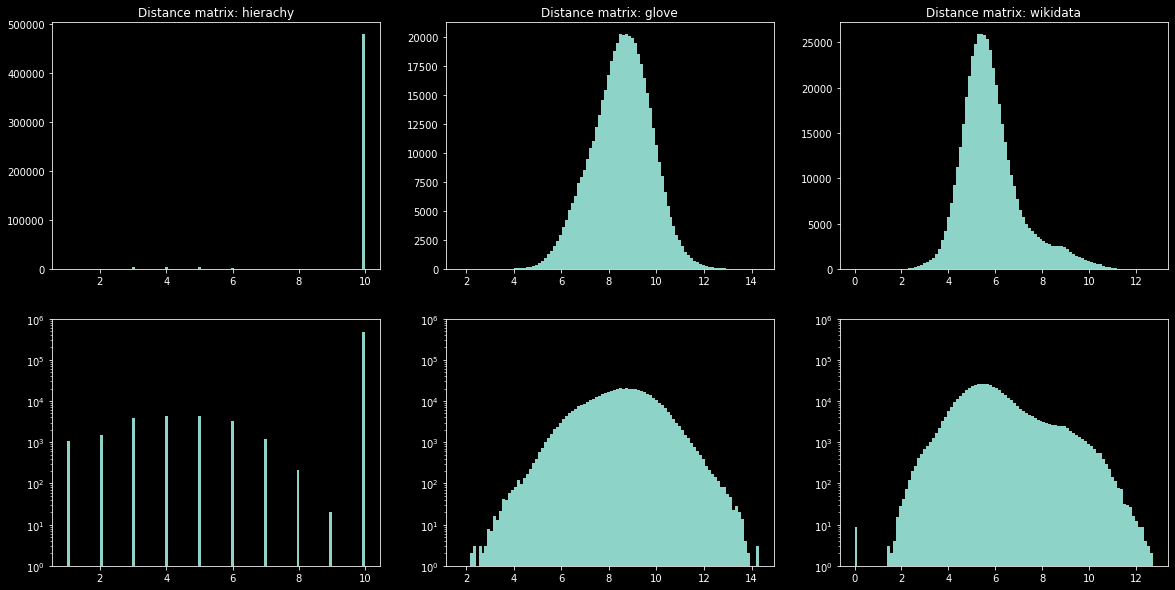

In [69]:
def plot_distinance_distribution(ax, k, v, log_scale=False):
    lower_triangle_flattened = np.tril(v).flatten()
    ax.hist(lower_triangle_flattened[lower_triangle_flattened.nonzero()[0]], bins=100)
    if log_scale:
        ax.set_yscale('log')
        ax.set_ylim(1, 1e6)
    else:
        ax.set_title(f"Distance matrix: {k}")
        # ax.set_ylim(0, 1e5)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, (k, v) in enumerate(distances_dict.items()):
    plot_distinance_distribution(axs[0, i], k, v, log_scale=False)
    plot_distinance_distribution(axs[1, i], k, v, log_scale=True)

fig.show()    

Mantel test for distance matrices correlations

In [84]:
for x, y in list(combinations(distances_dict.items(), 2)):
    corr, p, n = mantel(x[1], y[1])
    print(f"{x[0]:10} {y[0]:10}  corr: {corr:.2f}  p: {p}  n: {n}")

hierachy   glove       corr: 0.14  p: 0.001  n: 1000
hierachy   wikidata    corr: 0.13  p: 0.001  n: 1000
glove      wikidata    corr: 0.16  p: 0.001  n: 1000
